<a href="https://colab.research.google.com/github/julianayuri/ReconhecimentoPadroes/blob/main/Atividade04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iris Dataset

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [2]:
X.shape, y.shape

((150, 2), (150,))

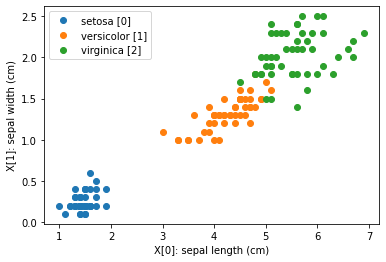

In [4]:
import matplotlib.pyplot as plt

for k in set(y):
  plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
plt.legend()
plt.xlabel(f"X[0]: {iris.feature_names[0]}")
plt.ylabel(f"X[1]: {iris.feature_names[1]}")
plt.show()

## Heurística básica (aula)


In [5]:
from collections import Counter
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
  return Counter(y).most_common(1)[0][0]


class ArvoreMaisComum(BaseEstimator, ClassifierMixin):
  def __init__(self):
    self.caracteristica = 0

  def fit(self, X, y):
    self.valor = np.mean(X[:,self.caracteristica])
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = ArvoreMaisComum()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = ArvoreMaisComum()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)

  def predict(self, X):
    y = np.empty((X.shape[0]))
    if hasattr(self, "resposta"):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

In [6]:
modelo = ArvoreMaisComum()
modelo.fit(X, y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9533333333333334,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

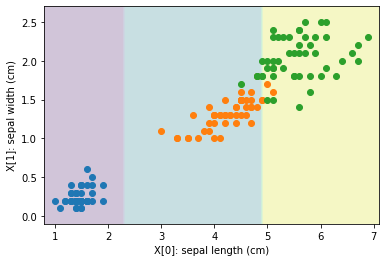

In [7]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

plotDecisao(ArvoreMaisComum(), X, y)

## Heurística melhorada (aula)

In [8]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i,k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades**2)
  return result

In [9]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezaMaiores = impureza(y[maiores])
  propMaiores = sum(maiores)/len(y)
  impurezaMenores = impureza(y[~maiores])
  propMenores = sum(~maiores)/len(y)
  impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
  return impurezaTotal, impurezaMaiores, impurezaMenores

In [10]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    #valor = (xmin+xmax)/2
    #valor = np.mean(x) #media
    valor = np.median(x) #mediana
    impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

In [11]:
def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return caracteristica, valores[caracteristica], impurezas[caracteristica]

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

class ArvoreMelhorada(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = ArvoreMelhorada()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = ArvoreMelhorada()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)

  def predict(self, X):
    y = np.empty((X.shape[0]))
    if hasattr(self, "resposta"):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

In [13]:
modelo = ArvoreMelhorada()
modelo.fit(X, y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

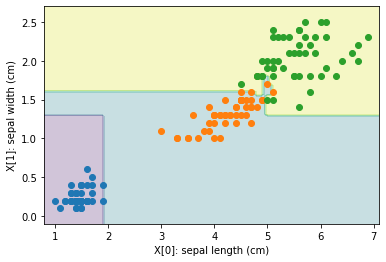

In [14]:
plotDecisao(ArvoreMelhorada(), X, y)

## Sklearn DecisionTreeClassifier

In [15]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier()
modelo.fit(X, y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

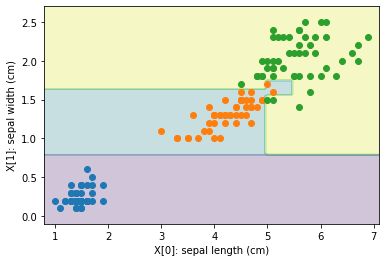

In [16]:
plotDecisao(DecisionTreeClassifier(), X, y)

# fri_c2_1000_5 Dataset

In [17]:
from sklearn.datasets import fetch_openml

fri = fetch_openml(name='fri_c2_1000_5', version=2)
X, y = fri.data, fri.target
X.shape, y.shape

((1000, 5), (1000,))

In [18]:
y = y.map({'N': int(0), 'P': int(1)})

## Heurística básica (aula)

In [19]:
from sklearn.model_selection import cross_validate

scores = cross_validate(ArvoreMaisComum(), X.values, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.74 , 0.725, 0.795, 0.785, 0.72 ]), 0.7529999999999999)

## Heurística melhorada (aula)


In [20]:
scores = cross_validate(ArvoreMelhorada(), X.values, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.905, 0.86 , 0.88 , 0.9  , 0.905]), 0.89)

## Sklearn DecisionTreeClassifier

In [21]:
scores = cross_validate(DecisionTreeClassifier(), X.values, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.91 , 0.875, 0.91 , 0.91 , 0.905]), 0.9020000000000001)

# transplant Dataset

In [22]:
transplant = fetch_openml(name='transplant', version=2)
X, y = transplant.data, transplant.target
X.shape, y.shape

((131, 3), (131,))

In [23]:
X.dtypes

obs    float64
e      float64
z      float64
dtype: object

In [24]:
y.dtypes

CategoricalDtype(categories=['P', 'N'], ordered=False)

In [25]:
y = y.map({'N': int(0), 'P': int(1)})

## Heurística básica (aula)

In [26]:
from sklearn.model_selection import cross_validate

scores = cross_validate(ArvoreMaisComum(), X.values, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.77777778, 1.        , 1.        , 1.        , 0.76923077]),
 0.9094017094017094)

## Heurística melhorada (aula)

In [27]:
scores = cross_validate(ArvoreMelhorada(), X.values, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.92592593, 1.        , 1.        , 1.        , 0.57692308]),
 0.9005698005698006)

## Sklearn DecisionTreeClassifier

In [28]:
scores = cross_validate(DecisionTreeClassifier(), X.values, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.81481481, 1.        , 1.        , 1.        , 0.69230769]),
 0.9014245014245015)

# breast Dataset

In [41]:
breast = fetch_openml(name='breast-w', version=1)
X, y = breast.data, breast.target
X.shape, y.shape

((699, 9), (699,))

In [42]:
X.dtypes

Clump_Thickness          float64
Cell_Size_Uniformity     float64
Cell_Shape_Uniformity    float64
Marginal_Adhesion        float64
Single_Epi_Cell_Size     float64
Bare_Nuclei              float64
Bland_Chromatin          float64
Normal_Nucleoli          float64
Mitoses                  float64
dtype: object

In [43]:
y = y.map({'malignant': int(0), 'benign': int(1)})

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

class AtributosNumericos(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.colunasNumericas = X.select_dtypes(include='number').columns
    return self
  def transform(self, X, y=None):
    return X[self.colunasNumericas]


pipenum = Pipeline([
    ('atributos_numericos', AtributosNumericos()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X = pipenum.fit_transform(X)

## Heurística básica (aula)

In [46]:
from sklearn.model_selection import cross_validate

scores = cross_validate(ArvoreMaisComum(), X, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.85      , 0.84285714, 0.92142857, 0.87142857, 0.79136691]),
 0.8554162384378212)

## Heurística melhorada (aula)

In [47]:
scores = cross_validate(ArvoreMelhorada(), X, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.88571429, 0.92142857, 0.96428571, 0.96428571, 0.95683453]),
 0.9385097636176774)

## Sklearn DecisionTreeClassifier

In [48]:
scores = cross_validate(DecisionTreeClassifier(), X, y.values)
scores['test_score'], np.mean(scores['test_score'])

(array([0.89285714, 0.93571429, 0.95      , 0.97142857, 0.94244604]),
 0.9384892086330936)

# Resultados

Inicialmente foi utilizado do dataset íris para rodar os modelos. O primeiro modelo foi desenvolvido em aula e o nomeei de "Heurística básica" pois não foi selecionado a melhor característica para fazer a separação dos dados. O segundo também foi desenvolvido em aula e o nomeei de "Heurística melhorada" pois nesse classificador foi utilizado as melhores características para fazer a separação dos dataset através da pesquisa de menor impureza. E por fim, foi utilizado o classificar "DecisionTreeClassifier" do próprio sklearn. Nesse Dataset foi possível notar que a heurística básica teve um desempenho inferior aos outros dois que obtiveram o mesmo resultado. 

Após essa validação, os três classificadores também foram testados com outros três datasets. Os resultados com os datasets "fri_c2" e "breast" foram bem semelhantes ao do Íris, no qual o classificar da heurística básica foi inferior e os outros dois tiveram um desempenho bem semelhante. Para o dataset "transplant" os três classificares tiveram um desempenho semelhante, sendo que o da heurística básica foi um pouco melhor que os demais. Provavelmente isso aconteceu por conta das características do dataset (poucas linhas e colunas). 